In [1]:
import pandas as pd
import matplotlib.pyplot  as plt

Import data

In [2]:
trades = pd.read_csv(r"filepath\trades.csv")
market_data = pd.read_csv(r"filepath\market_data.csv")
positions_front = pd.read_csv(r"filepath\positions_front.csv")
positions_books = pd.read_csv(r"filepath\positions_books.csv")

Mark-to-Market Value calculation

In [3]:
#merge trades and market data on product
mark_to_market = pd.merge(trades, market_data, how = 'inner', on = 'product')

#calculate MtM per transacion
mtm_value = mark_to_market['market_price'] * mark_to_market['quantity']
mark_to_market['mtm_value'] = mtm_value

#calculate PnL per transaction
pnl = (mark_to_market['market_price'] - mark_to_market['price']) * mark_to_market['quantity']
mark_to_market['pnl'] = pnl
calculated_pnl  = mark_to_market['pnl'].sum()
mark_to_market.head()

,trade_id,product,quantity,price,trade_date,market_price,mtm_value,pnl
0,T001,FX Forward,100000,1.250,2025-04-19,1.2600,126000.0,1000.0
1,T002,Bond,200000,102.000,2025-04-19,101.8000,20360000.0,-40000.0
2,T004,Bond,150000,101.500,2025-04-19,101.8000,15270000.0,45000.0
3,T003,Interest Rate Swap,500000,0.012,2025-04-19,0.0115,5750.0,-250.0


Plot market value

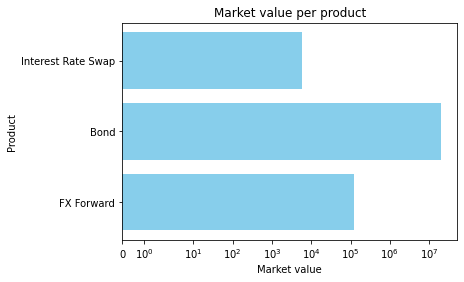

In [4]:
plt.barh(mark_to_market['product'], mark_to_market['mtm_value'], color = 'skyblue')
plt.xscale('symlog')
plt.ylabel("Product")
plt.xlabel("Market value")
plt.title("Market value per product")
plt.show()

Reconciliation - Front office vs Books

In [5]:
reconciliation = pd.merge(positions_front, positions_books, how='inner',on='trade_id', suffixes=('_front','_books') )
diff_position = reconciliation['position_value_front'] - reconciliation['position_value_books']
reconciliation['diff_position'] = diff_position
differences_rec = reconciliation[reconciliation['diff_position'] != 0]
pnl_front_sum = reconciliation['pnl_front'].sum()
pnl_books_sum = reconciliation['pnl_books'].sum()
reconciliation.head()

,trade_id,position_value_front,pnl_front,position_value_books,pnl_books,diff_position
0,T001,126000,1000,126000,1000,0
1,T002,204000,4000,203600,3600,400
2,T003,6000,-250,5750,-250,250
3,T004,152250,1125,152000,1000,250


In [6]:
differences_rec[['trade_id', 'diff_position']]

,trade_id,diff_position
1,T002,400
2,T003,250
3,T004,250


In [7]:
max_diff_trade = differences_rec.loc[differences_rec['diff_position'].abs().idxmax()]

Plot PnL comparison

<BarContainer object of 3 artists>

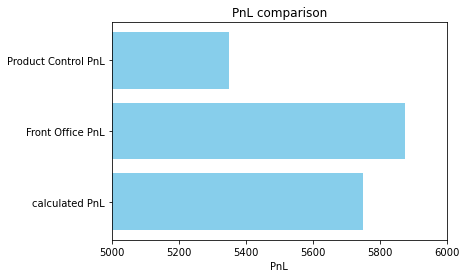

In [8]:
y = [round(calculated_pnl), pnl_front_sum, pnl_books_sum]
x = ['calculated PnL', 'Front Office PnL', 'Product Control PnL']
plt.xlim(5000, 6000)
plt.xlabel('PnL')
plt.title('PnL comparison')
plt.barh(x, y, color = 'skyblue')

In [9]:
if abs(calculated_pnl - pnl_front_sum) < 0.01:
    print("PnL matches — no issues.")
else:
    print("Discrepancy detected!")

Discrepancy detected!


Summary:

In [10]:
print("="*58)
print("DAILY PNL RECONCILIATION REPORT")
print("="*60)
print(f"Total calculated PnL (from MtM valuation):      {int(round(calculated_pnl,2))} PLN")
print(f"Total Front Office PnL:                         {round(pnl_front_sum, 2)} PLN")
print(f"Total Product Control PnL:                      {round(pnl_books_sum, 2)} PLN")
print("-"*60)
print(f"Biggest discrepancy found for trade_id:         {max_diff_trade['trade_id']}")
print(f"  - Front Office PnL:                           {max_diff_trade['pnl_front']} PLN")
print(f"  - Product Control PnL:                        {max_diff_trade['pnl_books']} PLN")
print(f"  - Difference:                                 {max_diff_trade['pnl_front'] - max_diff_trade['pnl_books']} PLN")
print("="*60)

DAILY PNL RECONCILIATION REPORT
Total calculated PnL (from MtM valuation):      5750 PLN
Total Front Office PnL:                         5875 PLN
Total Product Control PnL:                      5350 PLN
------------------------------------------------------------
Biggest discrepancy found for trade_id:         T002
  - Front Office PnL:                           4000 PLN
  - Product Control PnL:                        3600 PLN
  - Difference:                                 400 PLN
